> Testing of binary sentiment classification on a IMDb movie review dataset.

---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [2]:
import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor
from src.model import ReviewClassifier

In [3]:
from sklearn.model_selection import train_test_split

# Load

In [4]:
path = "data/steam/"

In [5]:
%%time
# Load dev set (10% of total data) as train
val = pd.read_csv(path + "dataset.csv")

CPU times: total: 13.2 s
Wall time: 13.3 s


In [6]:
# Get less samples
val, _ = train_test_split(val, train_size=50_000, stratify=val["review_score"])

In [7]:
# Ensure all strings
val["review_text"] = val.review_text.astype(str)

##### Save Target

In [8]:
# Save sentiment as boolean
y_val = val["review_score"] == 1
y_val

139063      True
3737728    False
1120506     True
4261071     True
4715916     True
           ...  
4743800     True
1222436     True
2376716     True
1077921     True
2080482     True
Name: review_score, Length: 50000, dtype: bool

# Preprocess

In [9]:
batch_size = 4000
n_processes = 4

maxlen = 200         # Number of words per review to consider
vocab_size = 20_000  # Size of vocabulary

prep_path = f"experiments/preprocessors/final.pickle"

##### Load from raw data

In [10]:
%%time
# Configure preprocessor based on comparison
prep = ReviewPreprocessor.load_from_pickle(prep_path)

# Preprocess text
X_val_norm = prep.normalize(val["review_text"], batch_size, n_processes)

# Convert to tensor of padded sequences
X_val = prep.to_tensor(X_val_norm)

CPU times: total: 32 s
Wall time: 1min 15s


##### View Before and After Preprocessing

In [11]:
print_idx = 8
print(val["review_text"].iloc[print_idx])
print("\n - - - - \n")
print(X_val_norm[print_idx], len(X_val_norm[print_idx]))
print("\n - - - - \n")
print(X_val[print_idx])

 Early Access Review

 - - - - 

[' ', 'ORG', 'ORG', 'ORG'] 4

 - - - - 

tf.Tensor(
[2200   18   18   18    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   

# Model

##### Load Model

In [12]:
# From saved model (doesn't work with attn scores)
#model = keras.models.load_model("experiments/models/final_model")

# From checkpoint
embed_dim = 32  # Attention output size
num_heads = 2   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 1.0e-2    # L2 Reg based on comparison
dropout = 0.3   # Dropout based on comparison
cp_path = "experiments/model_checkpoints/"
model = ReviewClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)
model.load_weights(cp_path + f"final.ckpt")

In [13]:
model.predict(X_val[:5])

1/1 [==============================] - 1s 1s/step


array([[4.5831809e-09, 1.0833594e-07, 5.6126679e-04, 1.6003238e-01,
        8.3940625e-01],
       [6.2224829e-01, 2.3528887e-01, 8.2446501e-02, 3.2898024e-02,
        2.7118258e-02],
       [7.9264246e-05, 7.8842632e-04, 4.2494420e-02, 4.5906463e-01,
        4.9757329e-01],
       [6.4108270e-01, 8.6364768e-02, 2.2404980e-02, 3.6487341e-02,
        2.1366027e-01],
       [1.1519497e-01, 8.3099179e-02, 9.5633812e-02, 2.1412125e-01,
        4.9195072e-01]], dtype=float32)

# Evaluate

In [14]:
# Get probabilities per class
y_pred = model.predict(X_val)

1563/1563 [==============================] - 3s 2ms/step


In [15]:
# Calculate continuous star rating based on probabilities
star_reg = tf.reduce_sum(y_pred * np.array([0, 1, 2, 3, 4]), axis=1)
star_reg

<tf.Tensor: shape=(50000,), dtype=float64, numpy=
array([3.83881693, 0.60740388, 3.4533568 , ..., 2.8843216 , 3.30248   ,
       2.97397922])>

In [16]:
# Determine if sentiment is negative or postiive
y_pred_binary = star_reg >= 2

In [17]:
print("binary accuracy: " + str((y_pred_binary == y_val).numpy().sum() / len(y_val)))
print("(compare to ~0.5)")

binary accuracy: 0.8207
(compare to ~0.5)


##### Visualize Attention

In [18]:
# Get attention scores
_, attns = model(X_val[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[7.3054373e-01, 1.6624185e-01, 1.0321448e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.0039635e-02, 1.8287657e-01, 5.6152601e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.7040391e-01, 8.0252208e-02, 3.4352941e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.8827841e-02, 4.5451877e-01, 4.6154755e-04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.5422137e-01, 3.2251629e-01, 6.3777760e-02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.8580580e-02, 3.7990185e-03, 1.3593315e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [19]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([0.73054373, 0.16624185, 0.10321448, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)>

<Original Text>
  This was a phenomenal game back when it released but it desperately beckons for new updates. Unless you are somone with an old-school crt monitor and ancient hardware or just someone who has to have it, skip this one.  If you're still going to buy it, enjoy an open world with a nice barter/trade system and addictive pirate ship battles. Trust me when I say: A remake WILL be made.  Sorry Sid.

<Preprocessed>
['this', 'was', 'a', 'phenomenal', 'game', 'back', 'when', 'it', 'released', 'but', 'it', 'desperately', 'for', 'new', 'updates', 'unless', 'you', 'are', 'with', 'an', 'old', 'school', 'monitor', 'and', 'ancient', 'hardware', 'or', 'just', 'someone', 'who', 'has', 'to', 'have', 'it', 'skip', 'this', 'one', 'if', 'you', "'", 're', 'still', 'going', 'to', 'buy', 'it', 'enjoy', 'an', 'open', 'world', 'with', 'a', 'nice', 'trade', 'system', 'and', 'addictive', 'pirate', 'ship', 'battles', 'trust', 'me', 'when', 'i', 'say', 'a', 'remake', 'will', 'be', 'made', 'person',

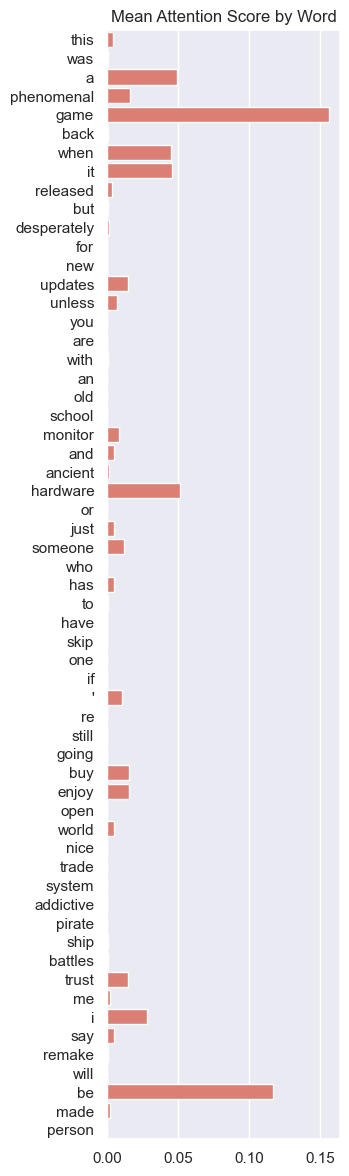

In [25]:
sample_idx = 18

# Get word sequences without oov words
in_seq = X_val_norm[sample_idx][:maxlen]
in_seq = [tok for tok in prep.tokenizer.sequences_to_texts(prep.tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(val["review_text"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(3, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="#EC7063")

plt.title("Mean Attention Score by Word")

#plt.gca().set_yticklabels(in_seq)

plt.show()